In [ ]:
import pandas as pd
import requests

class CandlestickFinder:
    def __init__(self, name, required_count, target=None):
        self.name = name
        self.required_count = required_count
        self.target = target

    def has_pattern(self, data, ohlc, is_reversed):
        pass  # Implement this method in subclasses

class InvertedHammer(CandlestickFinder):
    def __init__(self, target=None):
        super().__init__('InvertedHammer', 1, target=target)

    def logic(self, idx):
        candle = self.data.iloc[idx]

        close = candle[self.close_column]
        open = candle[self.open_column]
        high = candle[self.high_column]
        low = candle[self.low_column]

        return (((high - low) > 3 * (open - close)) and
                ((high - close) / (.001 + high - low) > 0.6)
                and ((high - open) / (.001 + high - low) > 0.6))

def inverted_hammer(candles_df, ohlc=['open', 'high', 'low', 'close'], is_reversed=False):
    inverted_hammer_finder = InvertedHammer()
    inverted_hammer_finder.data = candles_df
    inverted_hammer_finder.close_column, inverted_hammer_finder.open_column, inverted_hammer_finder.high_column, inverted_hammer_finder.low_column = ohlc
    return inverted_hammer_finder.has_pattern(candles_df, ohlc, is_reversed)

if __name__ == "__main__":
    # Fetching candlestick data from Binance API
    response = requests.get('https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1d')
    candles_dict = response.json()

    # Creating DataFrame from the obtained data
    candles_df = pd.DataFrame(candles_dict,
                              columns=['T', 'open', 'high', 'low', 'close', 'V', 'CT', 'QV', 'N', 'TB', 'TQ', 'I'])

    # Convert timestamp to datetime
    candles_df['T'] = pd.to_datetime(candles_df['T'], unit='ms')

    # Check if inverted hammer pattern is present
    inverted_hammer_present = inverted_hammer(candles_df)

    print("Inverted hammer pattern detected:", inverted_hammer_present)


Inverted hammer pattern detected: None


[*********************100%%**********************]  1 of 1 completed
<ipython-input-12-2c58c3d1bd55>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['Cash'][i] = capital
<ipython-input-12-2c58c3d1bd55>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['Total'][i] = portfolio['Holdings'][i] + portfolio['Cash'][i]
<ipython-input-12-2c58c3d1bd55>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['Cash'][i] 

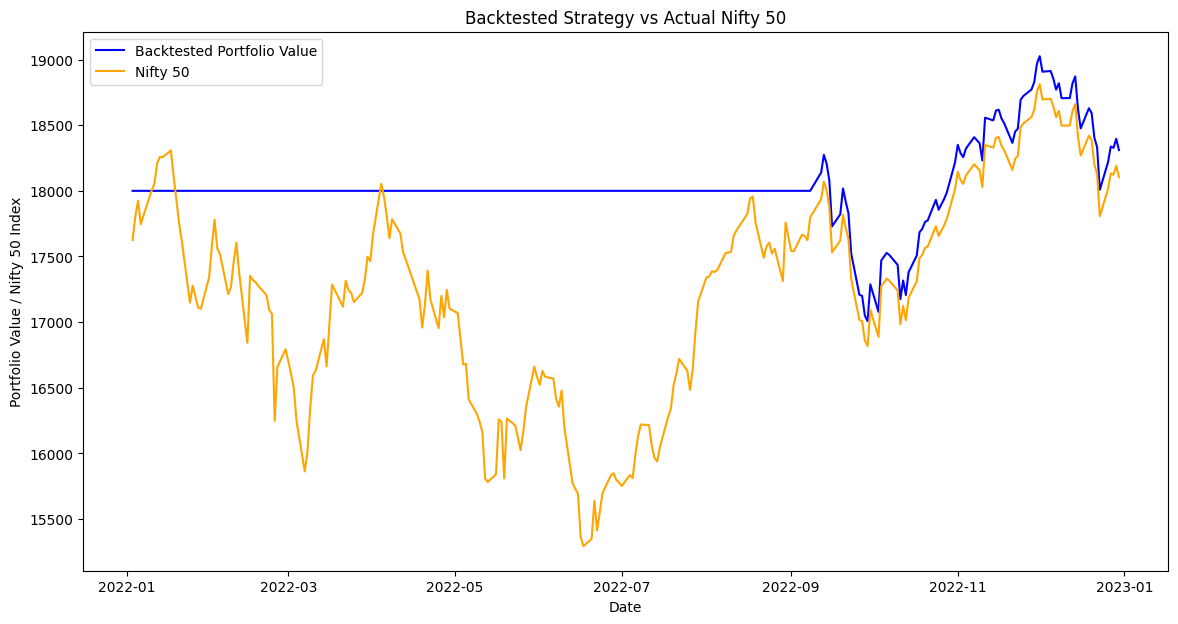

In [12]:
.import yfinance as yf
import matplotlib.pyplot as plt

# Define the trading strategy (Simple Moving Average Crossover)
def sma_crossover_strategy(data, short_window=50, long_window=200):
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = 0.0

    # Create short and long moving averages
    signals['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Generate trading signals
    signals['Signal'][short_window:] = np.where(signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, 0.0)

    # Calculate the difference between successive signals to detect buy and sell events
    signals['Position'] = signals['Signal'].diff()

    return signals

# Backtest the strategy on historical data
def backtest_strategy(data, signals):
    capital = 18000
    shares = 0
    portfolio = pd.DataFrame(index=data.index)
    portfolio['Holdings'] = 0
    portfolio['Cash'] = capital
    portfolio['Total'] = capital

    for i in range(1, len(signals)):
        price = data['Close'][i]

        if signals['Position'][i] == 1:
            shares = capital / price
            capital = 0
        elif signals['Position'][i] == -1:
            capital = shares * price
            shares = 0

        portfolio['Holdings'][i] = shares * price
        portfolio['Cash'][i] = capital
        portfolio['Total'][i] = portfolio['Holdings'][i] + portfolio['Cash'][i]

    return portfolio

# Fetch historical data
nifty_data = yf.download('^NSEI', start='2022-01-01', end='2023-01-01')

# Execute the strategy
signals = sma_crossover_strategy(nifty_data)
portfolio = backtest_strategy(nifty_data, signals)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(portfolio['Total'], label='Backtested Portfolio Value', color='blue')
plt.plot(nifty_data['Close'], label='Nifty 50', color='orange')
plt.title('Backtested Strategy vs Actual Nifty 50')
plt.xlabel('Date')
plt.ylabel('Portfolio Value / Nifty 50 Index')
plt.legend()
plt.show()
